# Spin Wave Simulation

Instrument: ARCS
* Ei=100meV
* Fermi chopper: 600 Hz
* T0: 120Hz
 
Sample: some crystal
* lattice parameters: 2, 2.5, 3        90 90 90
* Orientation: u,v = [1 0 2] and  [1 0 0]
* psi angles: -90, 90, step 2


## Step 0. some goodies

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import histogram.hdf as hh, histogram as H

## Step 1. create dir structure

In [2]:
# Change this!!!
workdir = "/SNS/users/lj7/simulations/ARCS/spinwave-demo/"
!mkdir -p {workdir}

In [3]:
%cd {workdir}
!ls

/SNS/users/lj7/simulations/ARCS/spinwave-demo
beam  samples  scattering


In [5]:
!mkdir -p samples/X/sampleassembly
!mkdir -p beam
!mkdir -p scattering

In [6]:
!find .

.
./samples
./samples/X
./samples/X/sampleassembly
./beam
./scattering


## Step 2. obtain beam simulation

In [8]:
!ln -s /SNS/users/lj7/simulations/ARCS/beam/100meV beam/100meV

In [9]:
%cd beam/100meV

/SNS/users/lj7/simulations/ARCS/beam/100meV


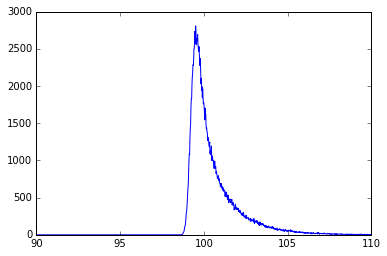

In [10]:
# check
import histogram.hdf as hh
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

## Step 3. Create sample assembly

In [21]:
%cd "{workdir}/samples/X/sampleassembly"

/SNS/users/lj7/simulations/ARCS/spinwave-demo/samples/X/sampleassembly


In [12]:
%cp -a /SNS/users/lj7/simulations/samples/spinwave/* .

In [22]:
%%file ./X.xyz
8
2 0 0    0 2.5 0  0 0 3
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0


Overwriting ./X.xyz


In [23]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=2; b:=2.5; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi; 
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.^2*(1-cospih2*cospik2*cospil2)) ^ (0.5)"
	S_Q="1"
	Emax="80*meV"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [26]:
a,b,c=2,2.5,3

from numpy import sin, cos, deg2rad
a1 = [a, 0, 0]
a2 = [0, b, 0]
a3 = [0, 0, c]

twopi = 2*np.pi
f = twopi/np.dot(a1, np.cross(a2, a3))
b1 = np.cross(a2,a3) * f
b2 = np.cross(a3,a1) * f
b3 = np.cross(a1,a2) * f
b1,b2,b3

(array([ 3.14159265,  0.        ,  0.        ]),
 array([ 0.        ,  2.51327412,  0.        ]),
 array([ 0.       ,  0.       ,  2.0943951]))

#### Orientation of the kernel
Here we need to use the convention that z is along beam, y vertical up.
The kernel has its own cartesian axis e’x e’y e’z. Because we know
u = 102 v = 100
, we have the basis vectors of the instrument coordinate system

    ez along b1 + 2*b3
    ex along b1
    

So we have them in the reciprocal cartesian axis

In [27]:
ez = b1 + 2*b3; ez /= np.linalg.norm(ez)
ex1 = b1
ey = np.cross(ez, ex1); ey/=np.linalg.norm(ey)
ex = np.cross(ey, ez)
ex, ey, ez

(array([ 0.8,  0. , -0.6]), array([ 0.,  1.,  0.]), array([ 0.6,  0. ,  0.8]))

The rotation matrix is define as
```
    ex.ex’ ex.ey’ ex.ez’ 
R = ey.ex’ ey.ey’ ey.ez’
    ez.ex’ ez.ey’ ez.ez’
```
So

In [28]:
R = np.array([ ex, ey, ez ])
Rflat = R.copy(); Rflat.shape = -1,
R, Rflat

(array([[ 0.8,  0. , -0.6],
        [ 0. ,  1. ,  0. ],
        [ 0.6,  0. ,  0.8]]),
 array([ 0.8,  0. , -0.6,  0. ,  1. ,  0. ,  0.6,  0. ,  0.8]))

Now we add an extra kernel parameter:

In [29]:
'orientation="%s"' % (','.join(str(e) for e in Rflat),)

'orientation="0.8,0.0,-0.6,0.0,1.0,0.0,0.6,0.0,0.8"'

In [30]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=4; b:=5; c:=6; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.^2*(1-cospih2*cospik2*cospil2)) ^ (0.5)"
	S_Q="1"
	Emax="80*meV"
	orientation="0.8,0.0,-0.6,0.0,1.0,0.0,0.6,0.0,0.8"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


** !!! Edit X-scatterer.xml **

In [32]:
!cat X-scatterer.xml

<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=4; b:=5; c:=6; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    cospih2:=cos(h*pi)^2; cospil2:=cos(l*pi)^2; cospik2:=cos(k*pi)^2; 
    (80.^2*(1-cospih2*cospik2*cospil2)) ^ (0.5)"
	S_Q="1"
	Emax="80*meV"
	orientation="0.8,0.0,-0.6,0.0,1.0,0.0,0.6,0.0,0.8"
	/>
    
  </KernelContainer>
  
</homogeneous_scatterer>

## Step 4. Scattering

In [33]:
%cd "{workdir}/scattering"

/SNS/users/lj7/simulations/ARCS/spinwave-demo/scattering


In [28]:
!rsync -a ~lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/* ./
!ls

scripts  template


In [29]:
%cd template

!ln -s ../../samples/X/sampleassembly

!ln -s ../../beam/100meV beam

%cd ..

/SNS/users/lj7/simulations/ARCS/spinwave-demo/scattering/template
/SNS/users/lj7/simulations/ARCS/spinwave-demo/scattering


In [36]:
%%file sim.yml

cluster:
  nodes: 1
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: off
  template: ./template


Overwriting sim.yml


In [35]:
!./scripts/sim.py --angle=30.0

SAMPLE_ANGLE=30.0 time ./scatter &> log.scatter
time ./create-nxs &> log.create-nxs

real	2m38.687s
user	20m26.507s
sys	3m7.381s
cp sim.nxs sim-30.0.nxs
mcvine instruments arcs nxs populate_metadata --type=Ei --beam_outdir=beam/out --nxs=sim-30.0.nxs
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)


## Step 5. Reduction

In [39]:
%cd "{workdir}/scattering"
!ls

/SNS/users/lj7/simulations/ARCS/spinwave-demo/scattering
config.py	   template    work_26.0   work_50.0   work_70.0
config.pyc	   work_-10.0  work_-30.0  work_-54.0  work_-74.0
create_bunch.py    work_10.0   work_30.0   work_54.0   work_74.0
run1		   work_-14.0  work_-34.0  work_-58.0  work_-78.0
run2		   work_14.0   work_34.0   work_58.0   work_78.0
runall		   work_-18.0  work_-38.0  work_-6.0   work_-82.0
scripts		   work_18.0   work_38.0   work_6.0    work_82.0
sim.yml		   work_-2.0   work_-42.0  work_-62.0  work_-86.0
slice_H00_-5,5.h5  work_2.0    work_42.0   work_62.0   work_86.0
slice_H00.h5	   work_-22.0  work_-46.0  work_-66.0  work_-90.0
slice_H00.nxs	   work_22.0   work_46.0   work_66.0   work_90.0
slice_H00.yml	   work_-26.0  work_-50.0  work_-70.0  X.xyz


First we reduce event-mode nexus data for each angle using Mantid

In [41]:
!ls work_2.0/reduced*

ls: cannot access work_2.0/reduced*: No such file or directory


In [17]:
!./scripts/reduce/reduceKeepingEvents_batch.py -90,90.1,4. 100 0,80,0.5

work_-90.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--90.0.nxs', '-90.0', '100', '0,0.5,80', 'reduced_-90.0.nxs']
work_-86.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--86.0.nxs', '-86.0', '100', '0,0.5,80', 'reduced_-86.0.nxs']
work_-82.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--82.0.nxs', '-82.0', '100', '0,0.5,80', 'reduced_-82.0.nxs']
work_-78.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--78.0.nxs', '-78.0', '100', '0,0.5,80', 'reduced_-78.0.nxs']
work_-74.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--74.0.nxs', '-74.0', '100', '0,0.5,80', 'reduced_-74.0.nxs']
work_-70.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--70.0.nxs', '-70.0', '100', '0,0.5,80', 'reduced_-70.0.nxs']
work_-66.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--66.0.nxs', '-66.0', '100', '0,0.5,80', 'reduced_-66.0.nxs']
work_-62.0 ['python', '../scripts/reduce/reduceKeepingEvents.py', 'sim--62.0

In [15]:
%%file slice_H00.yml

angles: -90,90.1,4.0
filename_pattern: work_%(angle)s/reduced_%(angle)s.nxs
lattice: 2., 2.5, 3., 90, 90, 90
orientation:
 u: 1, 0, 2
 v: 1,0,0
Eaxis:
 min: 0
 max: 80
 N: 160
Q_projections:
 U:
  proj: 1,0,0
  proj_name: H,0,0
  min: -5
  max: 0
  N: 251
 V:
  proj: 0,1,0
  proj_name: 0,K,0
  min: -0.3
  max: 0.3
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -.3
  max: .3
  N: 1
output: slice_H00.nxs


Overwriting slice_H00.yml


In [8]:
!cp /SNS/users/lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/scripts/config.py .

In [16]:
! PYTHONPATH=$PWD:$PYTHONPATH ./scripts/reduce/getaslice.py slice_H00.yml

-90.0 work_-90.0/reduced_-90.0.nxs
FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 33.31 seconds
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents successful, Duration 0.53 seconds
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents successful, Duration 0.65 seconds
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents successful, Duration 0.70 seconds
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents successful, Duration 0.90 seconds
CompressEvents-[Notice] CompressEvents started
CompressEvents-[Notice] CompressEvents successful, Duration 0.42 seconds
CompressEvents-[Notice] CompressEv

In [17]:
!./scripts/reduce/slice2hist.py slice_H00.nxs slice_H00.h5

FrameworkManager-[Notice] Welcome to Mantid 3.6.100
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid3.6.100
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 1.81 seconds


plot z in (0, 1e-06)


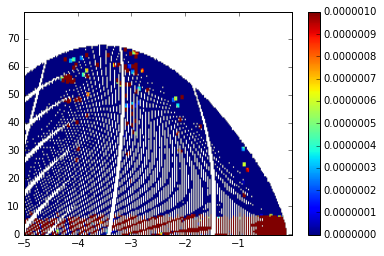

In [19]:
H.plot(hh.load("./slice_H00.h5"), min=0, max=1e-6)